# Imports

In [ ]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [ ]:
%%capture
%env TORCH=2.5.1+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, global_add_pool, GraphConv
from torch_geometric.datasets import TUDataset

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

import os
import csv
import os.path as osp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, nc):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(nc):
            self.convs.append(GraphConv(in_channels, hidden_channels, aggr='add', bias=True))
            in_channels = hidden_channels

        if nc != 0:
            self.mlp = MLP([hidden_channels, hidden_channels, out_channels])
        else:
            self.mlp = MLP([in_channels, hidden_channels, out_channels])

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        x = global_add_pool(x, batch)

        return self.mlp(x)

In [ ]:
def train(loader, model, optimizer):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
def test(loader, model):
    model.eval()

    total_correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

# Vary test/train split used.

In [ ]:
m_ndl3 = [595, 4039, 4067, 4317, 27048, 27524]
total_num = [600, 4110, 4127, 4337, 27770, 27770]
best_possible = []
for i in range(len(m_ndl3)):
    best_possible.append(m_ndl3[i]/total_num[i])

#dataset_name_list = ["ENZYMES", "NCI1", "NCI109", "Mutagenicity", "MCF-7", "MCF-7H", ]
# if we fix number of parameters, then this should tell us how hard it is to learn?
color_complexity3 = [15208, 22948, 23411, 18309, 188976, 257361]

print(best_possible)

[0.9916666666666667, 0.9827250608272506, 0.9854615943784831, 0.9953885174083468, 0.9740007202016565, 0.9911415196254951]


Processing...
Done!


Train %: 90
Rep 1
Starting accuracy, Train Acc: 49.475, Test Acc: 50.971
Epoch: 010, Train Acc: 69.448, Test Acc: 64.806, Loss: 0.546
Epoch: 020, Train Acc: 75.585, Test Acc: 72.573, Loss: 0.514
Epoch: 030, Train Acc: 74.240, Test Acc: 72.330, Loss: 0.477
Epoch: 040, Train Acc: 79.408, Test Acc: 74.029, Loss: 0.458
Epoch: 050, Train Acc: 73.109, Test Acc: 69.903, Loss: 0.449
Epoch: 060, Train Acc: 78.627, Test Acc: 73.786, Loss: 0.437
Epoch: 070, Train Acc: 80.861, Test Acc: 76.456, Loss: 0.416
Epoch: 080, Train Acc: 73.701, Test Acc: 70.388, Loss: 0.430
Epoch: 090, Train Acc: 80.431, Test Acc: 75.971, Loss: 0.433
Epoch: 100, Train Acc: 83.230, Test Acc: 74.272, Loss: 0.397
Epoch: 110, Train Acc: 82.450, Test Acc: 76.456, Loss: 0.384
Epoch: 120, Train Acc: 81.104, Test Acc: 75.243, Loss: 0.349
Epoch: 130, Train Acc: 79.569, Test Acc: 73.301, Loss: 0.381
Epoch: 140, Train Acc: 82.584, Test Acc: 75.243, Loss: 0.388
Epoch: 150, Train Acc: 82.746, Test Acc: 75.971, Loss: 0.360
Epoch: 160, 

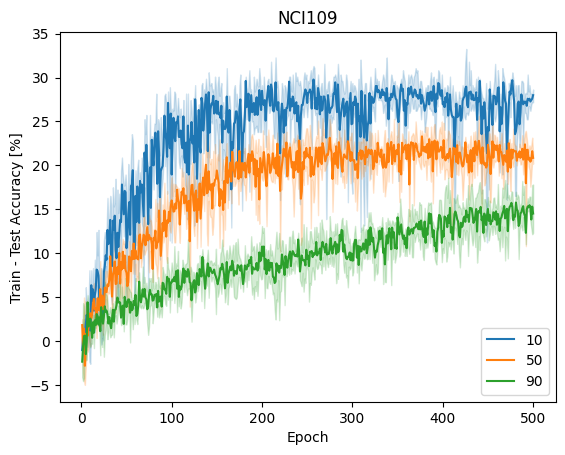

In [ ]:
batch_size = 128
num_layers = 3
lr = 0.001
epochs = 500 #500
num_reps = 3
hidden_channels = 64

train_pcts = [90, 50, 10]

# dataset_name_list = ["ENZYMES", "NCI1", "NCI109", "Mutagenicity", "MCF-7", "MCF-7H"]
dataset_name = "NCI109"
dataset = TUDataset('./datasets', name=dataset_name).shuffle()
raw_data = []

for i, train_pct in enumerate(train_pcts):
    print(f'Train %: {train_pct}')
    for it in range(num_reps):
        print(f'Rep {it+1}')
        dataset.shuffle()

        train_dataset = dataset[-train_pct*len(dataset) // 100:]
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

        test_dataset = dataset[:len(dataset) // 10]
        test_loader = DataLoader(test_dataset, batch_size)
        model = Net(dataset.num_features, hidden_channels, dataset.num_classes, num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_acc = test(train_loader, model) * 100.0
        test_acc = test(test_loader, model) * 100.0
        print(f'Starting accuracy, Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}')
        for epoch in range(1, epochs + 1):
            loss = train(train_loader, model, optimizer)
            train_acc = test(train_loader, model) * 100.0
            test_acc = test(test_loader, model) * 100.0
            if epoch % 10 == 0:
                print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}, Loss: {loss:.3f}')

            raw_data.append(
                {'epoch': epoch, 'test': test_acc, 'train': train_acc, 'diff': train_acc - test_acc, 'it': it, 'num_layers': num_layers, 'train_pct': train_pct,
                    'hidden_channels': hidden_channels, 'iteration': it}) #'diff_paper': test_acc - paper_mean_errors[dataset_name]

data = pd.DataFrame.from_records(raw_data)
data = data.astype({'epoch': int})

# LINEPLOT
ax = sns.lineplot(data=data, x='epoch', y='diff', palette=sns.color_palette()[:len(train_pcts)], hue='train_pct')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set(title=dataset_name, xlabel='Epoch', ylabel='Train - Test Accuracy [%]')

plt.legend(loc='lower right')
# plt.legend().remove()
plt.savefig(str(dataset_name) + "_train_split" + ".pdf")
plt.show()

In [ ]:
data.to_csv(str(dataset_name) + "_train_split" + ".csv")

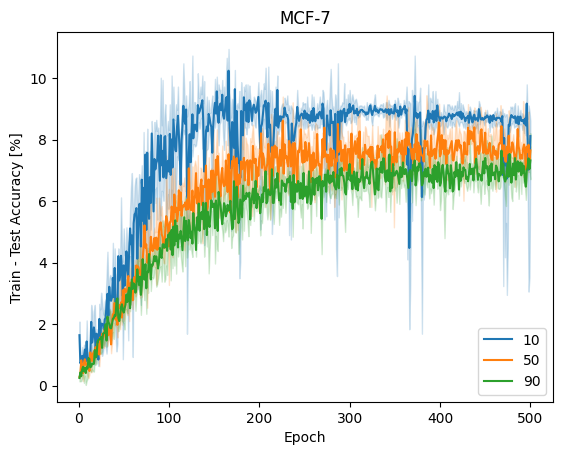

In [ ]:
ax = sns.lineplot(data=data, x='epoch', y='diff', palette=sns.color_palette()[:len(train_pcts)], hue='train_pct')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set(title=dataset_name, xlabel='Epoch', ylabel='Train - Test Accuracy [%]')
plt.legend(loc='lower right')
plt.savefig(str(dataset_name) + "_train_split" + ".pdf")

In [ ]:
ds_name_list = ["ENZYMES", "NCI1", "NCI109", "Mutagenicity", "MCF-7", "MCF-7H", ]
for ds_name in ds_name_list:
    fp = osp.abspath('')
    path = osp.join(osp.dirname(osp.realpath(fp)), '..', 'data', 'TU')
    ds = TUDataset(path, name=ds_name).shuffle()
    print(f"{ds_name}: {len(ds)}, {ds.num_classes}")

ENZYMES: 600, 6


Processing...
Done!


NCI1: 4110, 2


Processing...
Done!


NCI109: 4127, 2


Processing...
Done!


Mutagenicity: 4337, 2


Processing...
Done!


MCF-7: 27770, 2


Processing...
Done!


MCF-7H: 27770, 2


# Table

In [ ]:
df = pd.read_csv("MCF-7H_train_split.csv")
df[df['epoch'] == 500].groupby('train_pct').agg({'train': ['mean', 'std'], 'test': ['mean', 'std']})

train                 test          
                 mean       std       mean       std
train_pct                                           
10         100.000000  0.000000  91.453607  0.270276
50          99.793542  0.108350  93.254111  0.447357
90          99.650569  0.048235  93.662225  0.108030